# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

#FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:55<00:00, 518File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

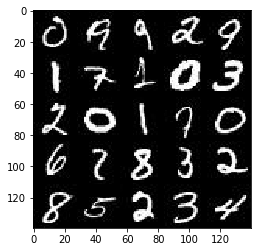

In [1]:

import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

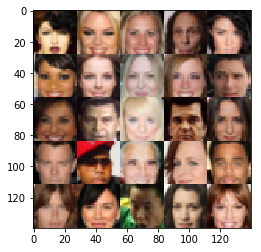

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32,(None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1.0
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 1.0
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        # 14x14x128 now

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=keep_prob)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                 labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                       labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #from IPython.core.debugger import Tracer; Tracer()()
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    #from IPython.core.debugger import Tracer; Tracer()()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps += 1
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 4.2288
Epoch 1/2... Discriminator Loss: 3.8159... Generator Loss: 0.0961
Epoch 1/2... Discriminator Loss: 2.7983... Generator Loss: 0.1817
Epoch 1/2... Discriminator Loss: 1.6000... Generator Loss: 0.6868
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.5465
Epoch 1/2... Discriminator Loss: 1.9548... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 3.8347... Generator Loss: 0.4433
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 0.7060


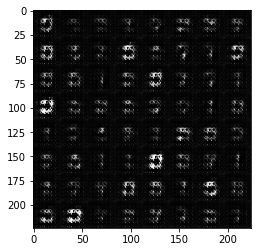

Epoch 1/2... Discriminator Loss: 1.8813... Generator Loss: 0.3963
Epoch 1/2... Discriminator Loss: 1.8456... Generator Loss: 0.5788
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 1.7223... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.7326... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.7877
Epoch 1/2... Discriminator Loss: 1.4909... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.7638
Epoch 1/2... Discriminator Loss: 1.7059... Generator Loss: 0.7244
Epoch 1/2... Discriminator Loss: 1.4827... Generator Loss: 0.7867


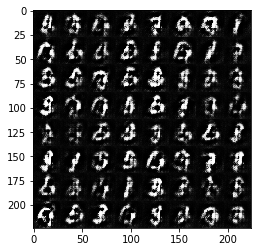

Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.9273
Epoch 1/2... Discriminator Loss: 1.5398... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.6215... Generator Loss: 1.0801
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.5060... Generator Loss: 0.6204
Epoch 1/2... Discriminator Loss: 1.5309... Generator Loss: 0.5453
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.9773
Epoch 1/2... Discriminator Loss: 1.4476... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 1.1341
Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.5337


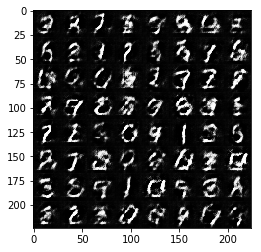

Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 1.0774
Epoch 1/2... Discriminator Loss: 1.3747... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.8009
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.8601
Epoch 1/2... Discriminator Loss: 1.5055... Generator Loss: 0.8297
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.9250
Epoch 1/2... Discriminator Loss: 1.4407... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 1.0746
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.8857


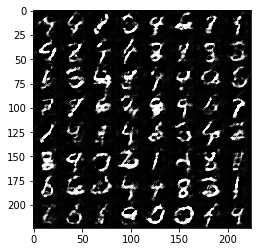

Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.4165... Generator Loss: 0.6874
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.8882
Epoch 1/2... Discriminator Loss: 1.3918... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.4225... Generator Loss: 0.6391
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.5830
Epoch 1/2... Discriminator Loss: 1.5664... Generator Loss: 0.5230


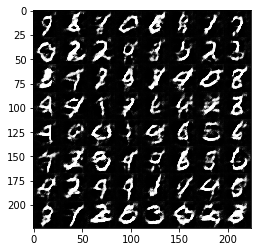

Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 1.0367
Epoch 1/2... Discriminator Loss: 1.3684... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 1.4528... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 1.3689... Generator Loss: 0.9016
Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 1.4517... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 0.6316
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.4782


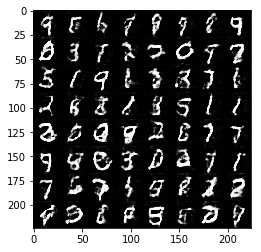

Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.7186
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.6980
Epoch 1/2... Discriminator Loss: 1.4805... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.6451
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 1.1818
Epoch 1/2... Discriminator Loss: 1.3571... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.5001
Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.4093... Generator Loss: 0.7209


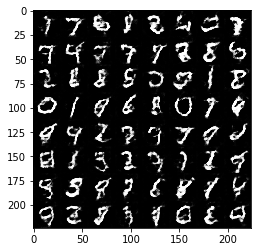

Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.9053
Epoch 1/2... Discriminator Loss: 1.5218... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.8431
Epoch 1/2... Discriminator Loss: 1.5515... Generator Loss: 1.1102
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.5347... Generator Loss: 0.4727
Epoch 1/2... Discriminator Loss: 1.4995... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.6926
Epoch 1/2... Discriminator Loss: 1.4771... Generator Loss: 0.5555


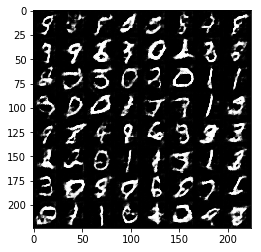

Epoch 1/2... Discriminator Loss: 1.4558... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 1.0603
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.8755
Epoch 1/2... Discriminator Loss: 1.4438... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.4522... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.5065
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.6877
Epoch 1/2... Discriminator Loss: 1.4294... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.4401... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 0.5124


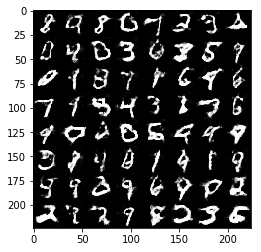

Epoch 1/2... Discriminator Loss: 1.4076... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.7911
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 0.6626
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 2.2832... Generator Loss: 2.0724
Epoch 2/2... Discriminator Loss: 1.3856... Generator Loss: 0.7679
Epoch 2/2... Discriminator Loss: 1.4150... Generator Loss: 0.7440
Epoch 2/2... Discriminator Loss: 1.4218... Generator Loss: 0.7259


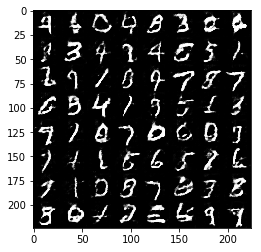

Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 1.0040
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.4801... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 0.7136
Epoch 2/2... Discriminator Loss: 1.3859... Generator Loss: 0.6141
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 2.2557... Generator Loss: 1.9708
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7712


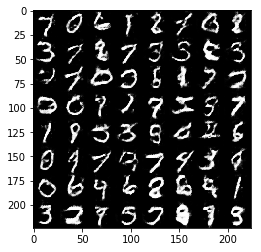

Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.8203
Epoch 2/2... Discriminator Loss: 1.4207... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.8924
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.6457
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.7137
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.3972... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 1.4162... Generator Loss: 0.5630
Epoch 2/2... Discriminator Loss: 1.4274... Generator Loss: 0.5610


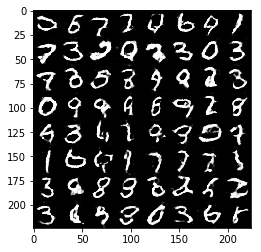

Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 1.1057
Epoch 2/2... Discriminator Loss: 1.6286... Generator Loss: 1.4283
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.7510
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 1.1851
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.6675


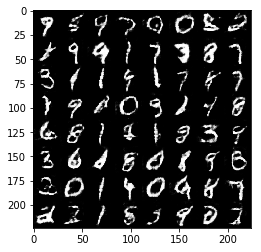

Epoch 2/2... Discriminator Loss: 1.4341... Generator Loss: 0.5869
Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.6959
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.7333... Generator Loss: 1.5319
Epoch 2/2... Discriminator Loss: 1.3760... Generator Loss: 0.6638
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.8000
Epoch 2/2... Discriminator Loss: 1.4018... Generator Loss: 0.5610
Epoch 2/2... Discriminator Loss: 1.6168... Generator Loss: 0.3969
Epoch 2/2... Discriminator Loss: 1.3590... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.4351... Generator Loss: 0.9283


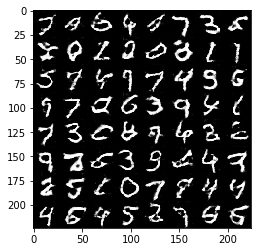

Epoch 2/2... Discriminator Loss: 1.4779... Generator Loss: 0.4826
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.7184
Epoch 2/2... Discriminator Loss: 1.5197... Generator Loss: 0.5057
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.7455
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 1.4145... Generator Loss: 0.6307
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.6746
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.4931
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.7737


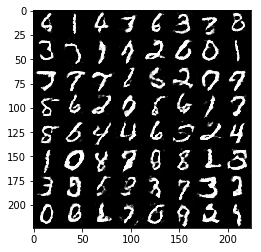

Epoch 2/2... Discriminator Loss: 1.5275... Generator Loss: 0.7183
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.7478
Epoch 2/2... Discriminator Loss: 1.5800... Generator Loss: 0.3946
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4148... Generator Loss: 0.6892
Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 0.5126
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 1.4163... Generator Loss: 0.7465
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.8371
Epoch 2/2... Discriminator Loss: 1.3568... Generator Loss: 0.7364


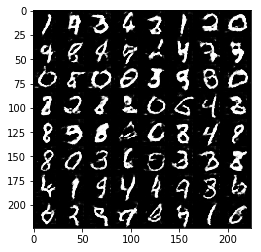

Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.5696
Epoch 2/2... Discriminator Loss: 1.4061... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 1.3986... Generator Loss: 0.7467
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.8076
Epoch 2/2... Discriminator Loss: 1.5050... Generator Loss: 0.4342
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.6383


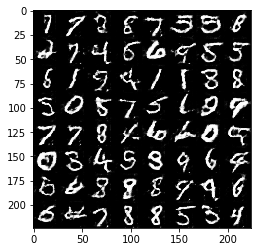

Epoch 2/2... Discriminator Loss: 1.4307... Generator Loss: 0.5771
Epoch 2/2... Discriminator Loss: 1.7909... Generator Loss: 1.5589
Epoch 2/2... Discriminator Loss: 1.4415... Generator Loss: 0.6274
Epoch 2/2... Discriminator Loss: 1.4169... Generator Loss: 0.6783
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.6962... Generator Loss: 0.3365
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.5968
Epoch 2/2... Discriminator Loss: 1.2359... Generator Loss: 0.7947
Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.9834


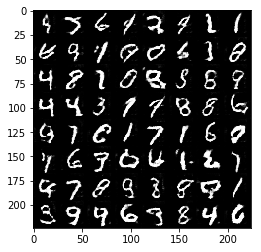

Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 1.3967... Generator Loss: 0.7134
Epoch 2/2... Discriminator Loss: 1.4130... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.9084
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8263


IndexError: list index out of range

In [11]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
#from IPython.core.debugger import Tracer; Tracer()()
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.2564... Generator Loss: 0.2512
Epoch 1/1... Discriminator Loss: 3.8773... Generator Loss: 0.2404
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 2.5015... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.6848... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 2.4596... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.9973... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.8570... Generator Loss: 0.5189


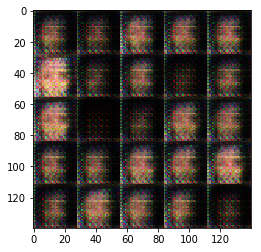

Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.8196... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.6435... Generator Loss: 0.5751
Epoch 1/1... Discriminator Loss: 1.9235... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.8894... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.6865... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.5686... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.9218... Generator Loss: 0.4847


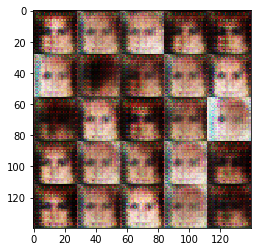

Epoch 1/1... Discriminator Loss: 1.5571... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.6867... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.7571... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.8853... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.8217... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.5657... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6947


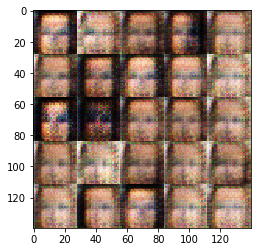

Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.5871... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.7442... Generator Loss: 0.6301
Epoch 1/1... Discriminator Loss: 1.5693... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.6352


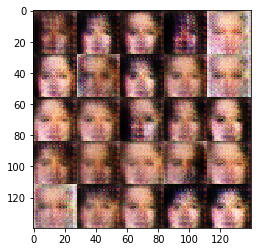

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4884... Generator Loss: 0.6553


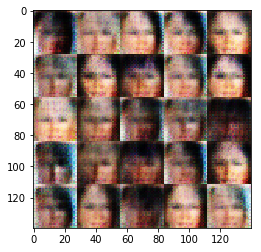

Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.6881


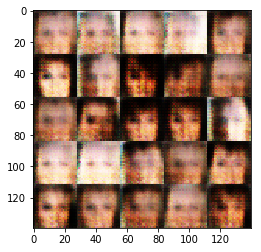

Epoch 1/1... Discriminator Loss: 1.6314... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.5303... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 0.7573


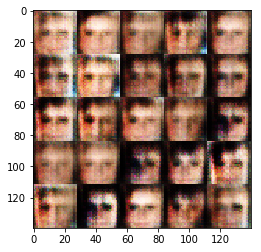

Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.7578


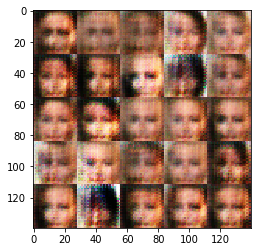

Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7227


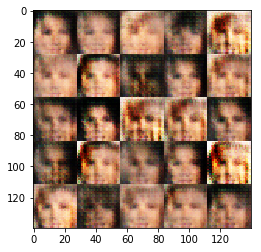

Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6772


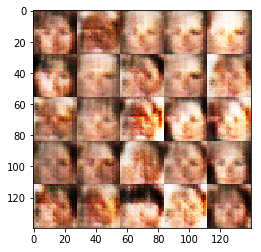

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.7140


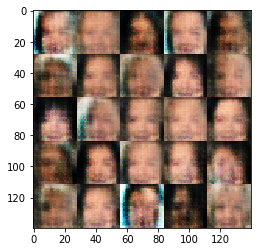

Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.5781... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.5567... Generator Loss: 0.7428


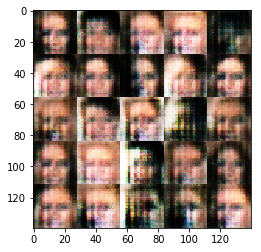

Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.4726... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7146


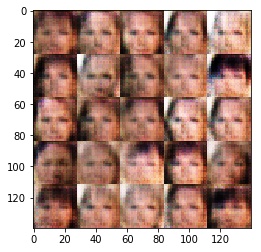

Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.8516


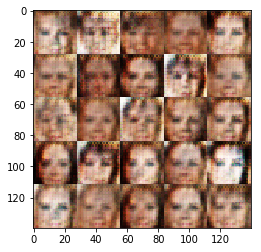

Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7403


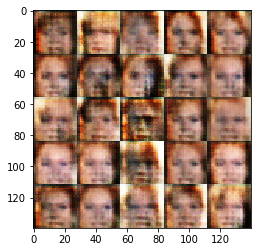

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7935


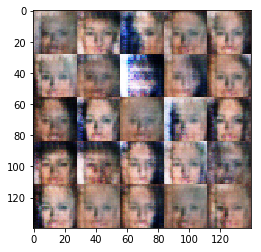

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.6603
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8096


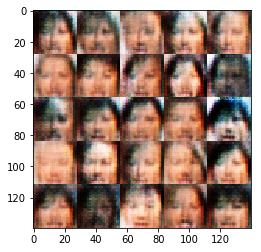

Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7484


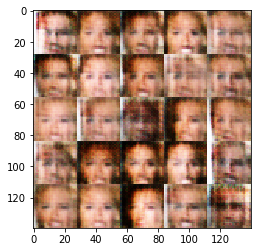

Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7883


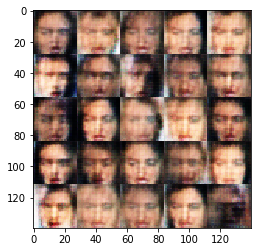

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.5276... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7266


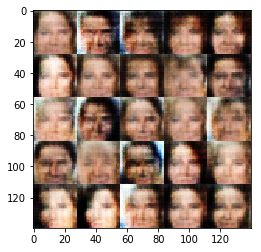

Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7574


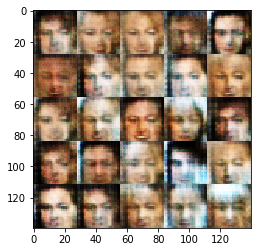

Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7393


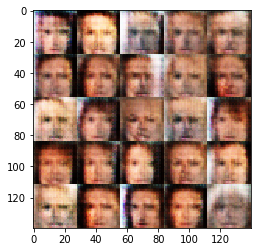

Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7492


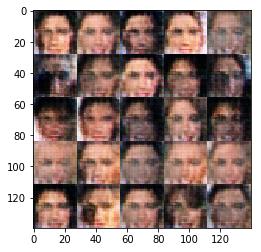

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7772


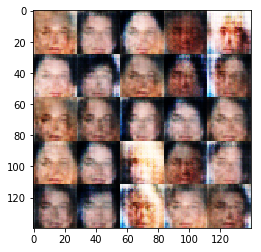

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.5826... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8377


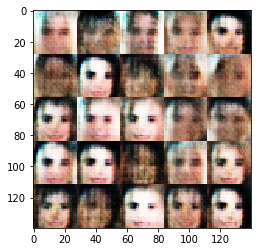

Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7166


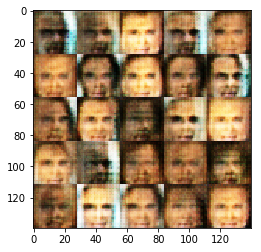

Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7739


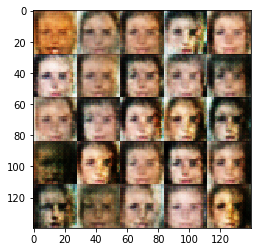

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4623... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7716


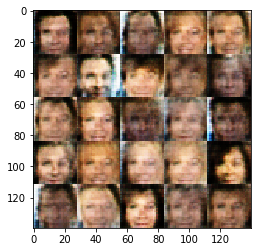

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7684


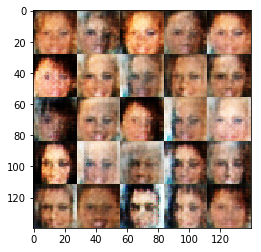

Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7618


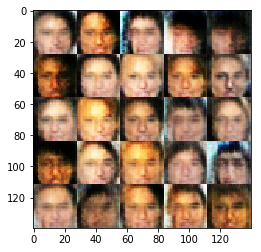

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7394


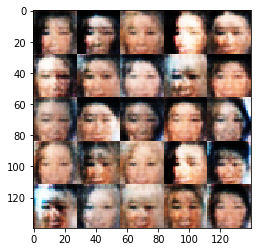

Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8256


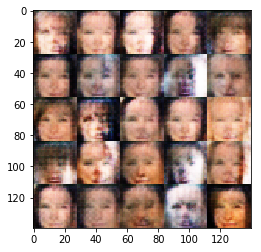

Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.6823


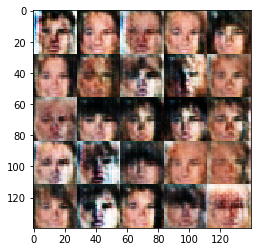

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7339


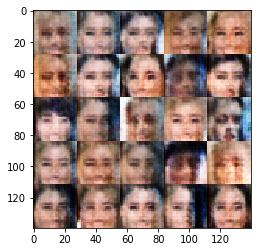

Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7688


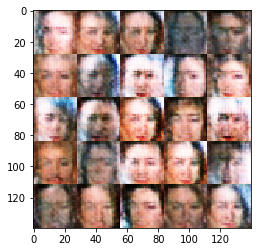

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8250


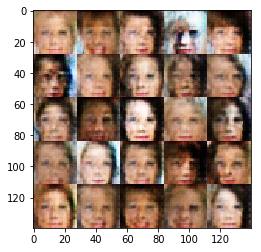

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.8262
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7933


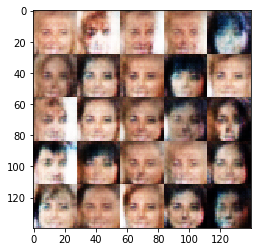

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8047


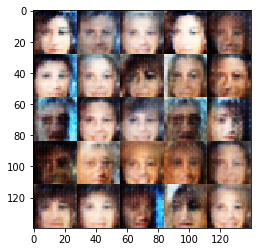

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7693


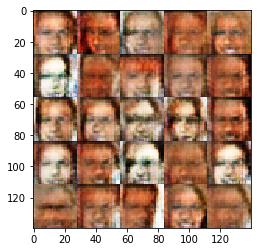

Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7926


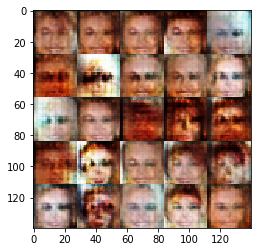

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7461


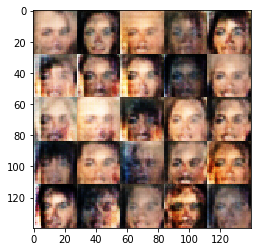

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7775


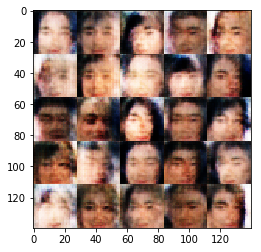

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.9079
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8220
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8375


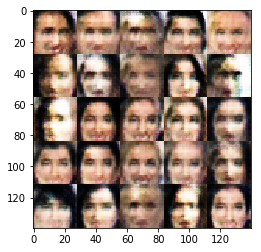

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8166


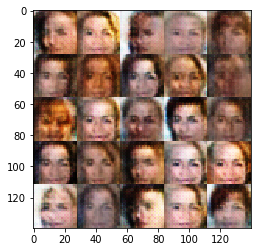

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7663


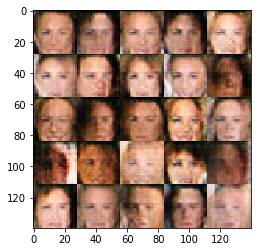

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.6902


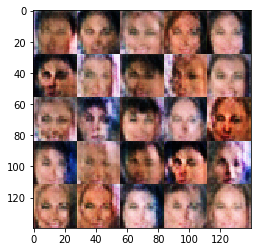

Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8975


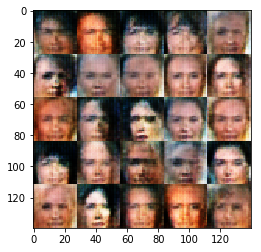

Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7933


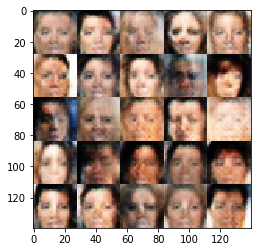

Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 0.7753


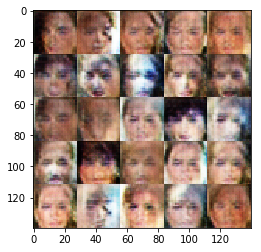

Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6579


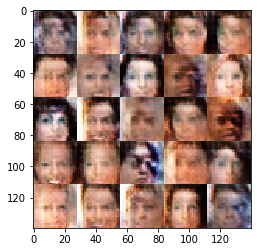

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8298


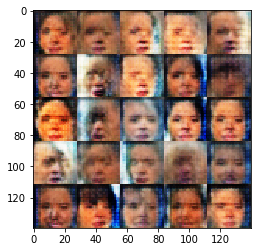

Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8151


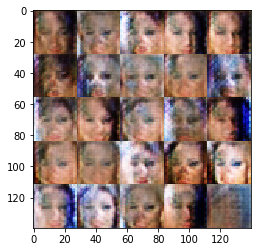

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.9378


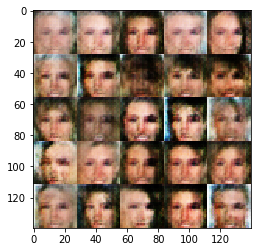

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7400


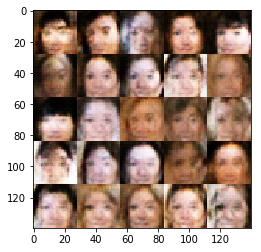

Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.8244


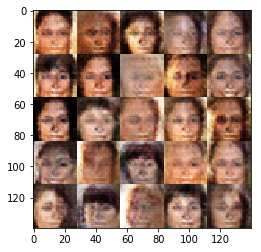

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6483


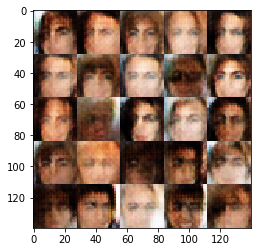

Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6930


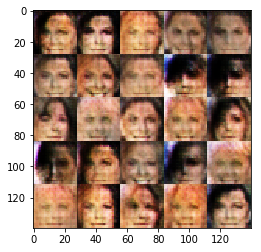

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7111


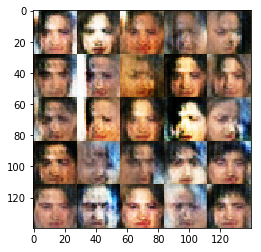

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7605


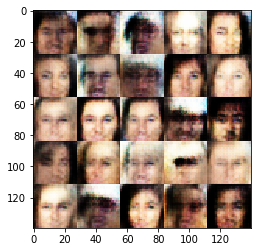

Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8316


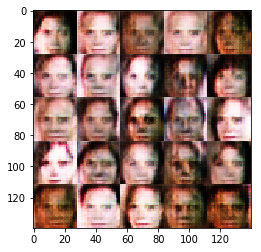

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7527


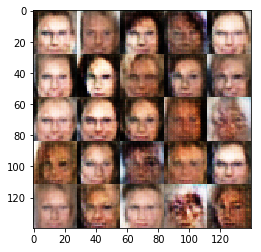

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7974


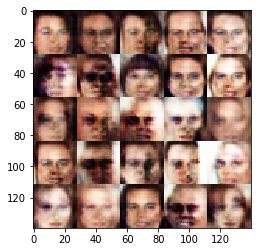

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.6581


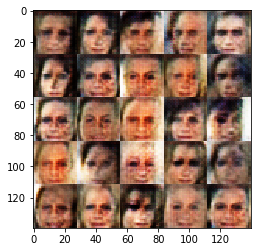

Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.9341


IndexError: list index out of range

In [11]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.